In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/CSE4095\ -\ NLP/Delivery-3/

/content/gdrive/MyDrive/CSE4095 - NLP/Delivery-3


In [ ]:
! pip install fasttext

     |████████████████████████████████| 68 kB 3.3 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3146814 sha256=60f65f201fdf8282cd672b0637f5425e596eae4eb046667dd21a744844aed8d8
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import tensorflow as tf
import fasttext
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.90.87.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.90.87.194:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
dataset = {}
with open('data/dataset.json', encoding='utf-8') as fr:
    dataset = json.load(fr)

In [ ]:
labels = {}
with open('data/labels.json', encoding='utf-8') as fr:
    labels = json.load(fr)

In [ ]:
splitted_data = {}
with open('data/splitted_data.json', encoding='utf-8') as fr:
    splitted_data = json.load(fr)

In [ ]:
X_train, X_test, y_train, y_test = [], [], [], []

for key in ['train', 'test']:
    for i in range(len(splitted_data[f'X_{key}'])):
        exec(f"X_{key}.append(dataset[splitted_data['X_{key}'][i]])")
        exec(f"y_{key}.append(splitted_data['y_{key}'][i])")

In [ ]:
with open('data/data.train.txt', 'w', encoding='utf-8') as fw:
    for i in range(len(X_train)):
        label = '-'.join(y_train[i].split())
        fw.write(f'__label__{label} {X_train[i]}\n')

with open('data/data.test.txt', 'w', encoding='utf-8') as fw:
    for i in range(len(X_test)):
        label = '-'.join(y_test[i].split())
        fw.write(f'__label__{label} {X_test[i]}\n')

In [ ]:
model = fasttext.train_supervised('data/data.train.txt', dim=512, epoch=50)

In [ ]:
model.save_model('results/fastttext_model.bin')

In [ ]:
lines = []
with open('data/data.test.txt', encoding='utf-8') as fr:
    lines = fr.readlines()

In [ ]:
y_pred = []
y_true = []
for test_instance in lines:
    text, label = ' '.join(test_instance.split()[1:]), test_instance.split()[0]
    predicted_label = model.predict(text)[0][0]
    y_pred.append(predicted_label[9:])
    y_true.append(label[9:])

In [ ]:
le = LabelEncoder()
le.fit(y_true)
y_true = le.transform(y_true)
y_pred = le.transform(y_pred)

In [ ]:
cr = classification_report(y_true, y_pred, target_names=le.classes_)
print(cr)

                              precision    recall  f1-score   support

       Aldatmaya-Yönelik-Suç       0.92      0.93      0.92       237
          Cana-Kastetme-Suçu       0.87      0.73      0.80        64
         Cinsel-Saldırı-Suçu       0.97      0.90      0.93       148
                     Hakaret       0.74      0.68      0.71       118
Kanuna/Yasaya-Muhalefet-Olma       0.89      0.89      0.89       352
                       Other       0.76      0.80      0.78       493
                      Tehdit       0.73      0.78      0.75       359
                 Trafik-Suçu       0.93      0.93      0.93        41
       Uyuşturucu-Madde-Suçu       0.98      0.97      0.98       232
                    Yaralama       0.92      0.86      0.89       546
                   undefined       0.98      0.99      0.99      2589
       İzinsiz-Mal-Alma-Suçu       0.88      0.90      0.89       390

                    accuracy                           0.92      5569
                  

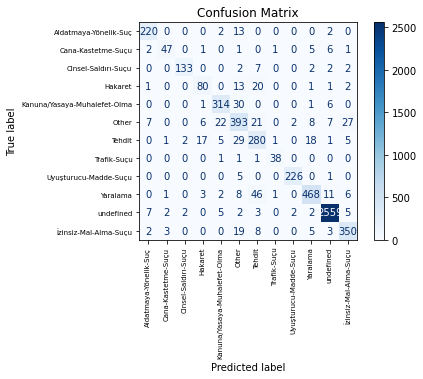

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=le.classes_,
        cmap=plt.cm.Blues,
        normalize=None,
    )
disp.ax_.set_title('Confusion Matrix')

plt.xticks(rotation = 90, fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('results/fasttext_cm.png', dpi=300, bbox_inches='tight')